In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import numpy
import copy
import qiskit
import ipyparallel as ipp
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit.providers.aer import AerSimulator
from openfermion.linalg import givens_decomposition_square as givensRotns
from qiskit.opflow import I,X,Y,Z,StateFn,AbelianGrouper
from qiskit.opflow.primitive_ops import PauliSumOp
from qiskit_nature.mappers.second_quantization import JordanWignerMapper,ParityMapper
from qiskit_nature.problems.second_quantization.electronic.builders import fermionic_op_builder
from qiskit.quantum_info import Pauli
from qiskit.chemistry import FermionicOperator
from qiskit.aqua.operators.legacy import op_converter
from openfermion.circuits import slater_determinant_preparation_circuit
from qiskit import QuantumCircuit,execute,QuantumRegister,ClassicalRegister
from qiskit import Aer
from qiskit.circuit.random import random_circuit
from joblib import Parallel,delayed
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.chemistry.components.variational_forms import UCCSD
import scipy

In [22]:
def egBandHamiltonian(U):
    #Getting chemical Potential for Half-Filling
    with open('../chem_pot_for_Half_Fill.txt','r') as f:
        lines=f.readlines()[1:]
        for line in lines:
            elems=line.split()
            if int(elems[0])==U:
                muHalf=float(elems[1]) #Chem Pot for a given Hubbard U
    #Getting the one body and two body interaction vertexes
    with open('../'+str(U)+'/v1e.dat','r') as f:
            lines=f.readlines()[1:]
            num_sites=4
            chem_pot=numpy.zeros((2*num_sites,2*num_sites))
            eg_h1=numpy.zeros((2*num_sites,2*num_sites))
            for line in lines:
                elems=line.split()
                eg_h1[int(elems[0])][int(elems[1])]=float(elems[2])
                eg_h1[int(elems[0])+num_sites][int(elems[1])+num_sites]=float(elems[2])
            for i in range(2*num_sites):
                chem_pot[i][i]=-muHalf
            eg_h1=eg_h1+chem_pot       
    with open('../'+str(U)+'/v2e.dat','r') as f:
        num_sites=4
        eg_h2_0=numpy.zeros((2*num_sites,2*num_sites,2*num_sites,2*num_sites))
        eg_h2_1=numpy.zeros((2*num_sites,2*num_sites,2*num_sites,2*num_sites))
        for line in f:
            if "#" in line:
                continue
            line = line.split()
            i,j,k,l = map(int, line[:4])
            val = float(line[4])
            if((i==j) and (k==l)):
                eg_h2_0[i,j,k,l] = eg_h2_0[i+num_sites,j+num_sites,k,l] = eg_h2_0[i,j,k+num_sites,l+num_sites] \
                = eg_h2_0[i+num_sites,j+num_sites,k+num_sites,l+num_sites] = 0.5*val  # convention with 0.5 factor included.
            else:
                eg_h2_0[i,j,k,l] = eg_h2_0[i+num_sites,j+num_sites,k+num_sites,l+num_sites] = 0.5*val  # convention with 0.5 factor included.
                eg_h2_1[i+num_sites,j+num_sites,k,l] = eg_h2_1[i,j,k+num_sites,l+num_sites] = 0.5*val
    return eg_h1,eg_h2_1,eg_h2_0

def qubitOp(h1,h2,mapping):  
    fer_op=fermionic_op_builder.build_ferm_op_from_ints(h1,h2)
    mapper=JordanWignerMapper() if mapping=='jordan_wigner' else ParityMapper()
    if mapping=='parity':
        qubit_conv = QubitConverter(mapper, two_qubit_reduction=True, z2symmetry_reduction="auto")
        qubit_op = qubit_conv.convert(fer_op, len(h1)//2)
    else:
        qubit_op=mapper.map(fer_op)
    return qubit_op 

def LRF_2_body_OD_terms(h2,mapping): #For 2 body off-diagonal terms
    def reshape_vec_to_mat(eigs):
        weight,vec1,vec2=eigs
        num_qubits=int(numpy.sqrt(vec1.shape[0]))
        L1=numpy.reshape(vec1,(num_qubits,num_qubits))
        L2=numpy.reshape(vec2,(num_qubits,num_qubits))
        return [numpy.sqrt(weight)*L1,numpy.sqrt(weight)*L2]
    #checksum  
    def higherRankRep(L):
        T=numpy.zeros((num_qubits,num_qubits,num_qubits,num_qubits))*1j
        for p in range(num_qubits):
            for q in range(num_qubits):
                for r in range(num_qubits):
                    for s in range(num_qubits):
                        T[p,q,r,s]=L[p,q]*L[r,s]
                        
        return T
    #constructing Low rank factorization circuits
    #Super matrix rep of four rank tensor (NxNxNxN)->(N^2xN^2)
    assert mapping!='parity' 'mapping needs to be of parity for this function'
    num_qubits=len(h2)
    N2=num_qubits*num_qubits
    h2_pq_rs=numpy.reshape(h2,(N2,N2))
    #Diagonalize Super matrix
    u,d,v=numpy.linalg.svd(h2_pq_rs,full_matrices=True)
    #Build Cholesky vectors
    Larr=[]
    arr=[(d[i],u[:,i],v[i]) for i in range(len(v)) if d[i]>1e-4]
    Larr=list(map(reshape_vec_to_mat,arr))
    #print(Larr)
    Larr=[Larr[i][0] for i in range(len(Larr))]
    qubit_h2=qubitOp(numpy.zeros((8,8)),h2,'parity')
    num_qubits_red=qubit_h2.num_qubits
    U1=PauliSumOp.from_list([('I'*num_qubits_red,numpy.cos(numpy.pi/4)),('IIIIIY',-1j*numpy.sin(numpy.pi/4))])
    U2=PauliSumOp.from_list([('I'*num_qubits_red,numpy.cos(numpy.pi/4)),('IIYIII',-1j*numpy.sin(numpy.pi/4))])
    rotH=(U2@U1@qubit_h2@U1.adjoint()@U2.adjoint()).reduce()
    qc=QuantumCircuit(num_qubits_red)
    qc=add_multiqubit_gate('IIIIIY',numpy.pi/4,qc)
    qc=add_multiqubit_gate('IIYIII',numpy.pi/4,qc)
    return qc,rotH,qubit_h2

def add_multiqubit_gate(pauli_string, param, circuit):
    num_qubits=circuit.num_qubits
    qr=QuantumRegister(num_qubits,'q')
    if pauli_string == 'I'*num_qubits:
        gate = 1
        for j in range(len(pauli_string)):
            gate = numpy.kron(gate, Pauli('I').to_matrix())
        gate *= -1j * np.sin(param)
        gate += numpy.cos(param) * np.eye(2**num_qubits)
        circuit.unitary(gate, qr, label=pauli_string)
    else:
        qubits_to_act_on = []
        gate = 1
        for j in range(len(pauli_string)):
            if pauli_string[j] != 'I':
                gate=numpy.kron(Pauli(pauli_string[j]).to_matrix(),gate)
                qubits_to_act_on.append(num_qubits-j-1)
        gate *= (-1j * numpy.sin(param))
        gate += numpy.cos(param) * numpy.eye(2**len(qubits_to_act_on))
        List_regs=[qr[i] for i in qubits_to_act_on]#[::-1]
        Label=pauli_string+"\n{:0.02f}".format(param.real)
        circuit.unitary(gate, List_regs, label = Label)
    return circuit  

def get_givens_rotns(h,mapping):
        num_qubits=len(h)
        qubitH=qubitOp(h,numpy.zeros((num_qubits,num_qubits,num_qubits,num_qubits)),mapping)
        num_qubits_red=qubitH.num_qubits
        H=qubitH.to_matrix()
        w,v=numpy.linalg.eigh(h)
        givens=givensRotns(v.T)[0]
        rotH=qubitH
        circ=QuantumCircuit(num_qubits_red)
        for rots in givens:
            for tup in rots:
                i,j,theta,phi=tup
                h1=numpy.zeros((num_qubits,num_qubits))*1j
                h1[i,j]=-1j
                h1[j,i]=1j
                qubit_h1=qubitOp(h1,numpy.zeros((num_qubits,num_qubits,num_qubits,num_qubits)),mapping)
                List=qubit_h1.primitive.to_list()
                Op=PauliSumOp.from_list([('I'*num_qubits_red,1)])
                for i in range(len(List)):
                    Op=PauliSumOp.from_list([('I'*num_qubits_red,numpy.cos(theta*List[i][1])),(List[i][0],1j*numpy.sin(theta*List[i][1]))])@Op
                    circ=add_multiqubit_gate(List[i][0], theta*List[i][1], circ)
                rotH=Op@rotH@Op.adjoint()
                rotH=rotH.reduce().reduce()
        return circ,rotH,qubitH
    
def doubly_decomposed_form(h1,h2_X,h2_D,mapping):

    #getting the givens rotation circuit and the rotated Hamiltonian for the one body terms
    circ_1_body,rotH_1_body,qubitH=get_givens_rotns(h1,mapping)
    #getting Cholesky vectors for two body off-diag terms
    circ_2_body,rotH_2_body,qubit_h2_X=LRF_2_body_OD_terms(h2_X,mapping)
    qubit_h2_D=qubitOp(numpy.zeros((8,8)),h2_D,'parity')
    circs_and_rotH_arr=[(circ_1_body,rotH_1_body,qubitH),(circ_2_body,rotH_2_body,qubit_h2_X),(qubit_h2_D)]
    return circs_and_rotH_arr

def expectation(h,circ):
    state=execute(circ,Aer.get_backend('statevector_simulator'),shots=1024).result().get_statevector()
    h_expec=state.conj()@h.to_matrix()@state
    return h_expec


def hamiltonian_expectation_in_doubly_decomposed(U,ansatz_circ,mapping):
    
    
    h1,h2_X,h2_D=egBandHamiltonian(U)
    circs_and_rotH=doubly_decomposed_form(h1,h2_X,h2_D,mapping)
    circ_rot_Arr=[ansatz_circ.copy(),ansatz_circ.copy(),ansatz_circ.copy()]
    h_part_expectation_arr=[]
    circ_rot_Arr[0]=circ_rot_Arr[0]+circs_and_rotH[0][0]
    qubit_ham=circs_and_rotH[0][1]
    h_part_expectation_arr.append(expectation(qubit_ham,circ_rot_Arr[0]))
    qubit_ham=circs_and_rotH[1][1]
    h_part_expectation_arr.append(expectation(qubit_ham,circ_rot_Arr[1]))
    h_part_expectation_arr.append(expectation(qubitOp(numpy.zeros((8,8)),h2_D,'parity'),ansatz_circ))
    return sum(h_part_expectation_arr)    
    
    

In [86]:
rand_circ=random_circuit(6,12)
U=7

In [172]:
eg_h1,eg_h2_X,eg_h2_D=egBandHamiltonian(U)

In [173]:

#complete Hamiltonian in parity encoding
qubitH=qubitOp(eg_h1,eg_h2_X+eg_h2_D,'parity')


In [174]:
#one body diagonal parts
circ,rotH,qubitH_1_body=get_givens_rotns(eg_h1,'parity')

In [175]:
print(rotH),print('\n'),print(qubitH_1_body)

(-18.909397921999993+3.469446951953614e-17j) * IIIIII
- 0.166149803024346 * ZIIIII
+ (4.893499283524346-1.1092357608687972e-16j) * ZZIIII
+ (4.893499283524346+2.6963019221421275e-33j) * IIZIII
+ (-0.16614980302434645-8.085607530171071e-19j) * IZZIII
+ (-0.1661498030243464+2.696301922142131e-33j) * IIIZII
+ (-0.16614980302434634-1.1092357608687982e-16j) * IIIZZI
+ (4.893499283524349-1.8488927466117464e-32j) * IIIIIZ
+ (4.893499283524348+4.136552504734431e-19j) * IIIIZZ


-18.909397921999993 * IIIIII
- 0.16165051950000014 * ZIIIII
- 0.16165051950000014 * ZZIIII
+ (4.8889999999999985-4.440892098500626e-16j) * IIZIII
+ 4.8889999999999985 * IZZIII
- 0.16165051950000014 * IIIZII
- 0.16165051950000014 * IIIZZI
+ 4.8889999999999985 * IIIIIZ
+ 4.8889999999999985 * IIIIZZ
+ 0.15081297099999993 * YYIIII
+ 0.15081297099999993 * XXZIII
+ (0.15081297099999993+1.3877787807814457e-17j) * ZXXIII
+ 0.15081297099999993 * IYYIII
+ 0.15081297099999993 * IIIYYI
+ (0.15081297099999993+1.3877787807814457e-17j

(None, None, None)

In [176]:
state_rand=execute(rand_circ,Aer.get_backend('statevector_simulator'),shots=1024).result().get_statevector()
circ1=rand_circ.copy()
circ1=circ1+circ

state1=execute(circ1,Aer.get_backend('statevector_simulator'),shots=1024).result().get_statevector()

state1.conj()@rotH.to_matrix()@state1,state_rand.conj()@qubitH_1_body.to_matrix()@state_rand

((-21.611743558657217+4.440892098500626e-16j),
 (-21.61174355865721+8.881784197001252e-16j))

In [177]:
#two body diagonal terms
qubitH_2_D=qubitOp(numpy.zeros((8,8)),eg_h2_D,'parity')

In [178]:
circs_and_rotH=doubly_decomposed_form(eg_h1,eg_h2_X,eg_h2_D,'parity')

In [179]:
circ_2_body,rotH_2_body,qubit_h2_X=LRF_2_body_OD_terms(eg_h2_X,'parity')

In [180]:
circ2=rand_circ.copy()
circ3=circ2+circ_2_body

In [181]:
print(rotH_2_body),print('\n',qubit_h2_X)

0.5249999999999998 * IIZIIZ
+ (-0.5249999999999998+5.551115123125783e-17j) * IZZIIZ
- 0.5249999999999998 * IIZIZZ
+ (0.5249999999999998-5.551115123125783e-17j) * IZZIZZ

 0.5249999999999998 * IIXIIX
+ (-0.5249999999999998+5.551115123125783e-17j) * IZXIIX
- 0.5249999999999998 * IIXIZX
+ (0.5249999999999998-5.551115123125783e-17j) * IZXIZX


(None, None)

In [182]:
expectation(rotH_2_body,circ3),expectation(qubit_h2_X,circ2)

((0.007892799038355616+1.0408340855860843e-17j),
 (0.00789279903835558-5.204170427930421e-18j))

In [183]:
def Energy_Estimator(circ,Op,num_shots):
    def getCounts(Input):
        circ,num_shots=Input
        circ1=circ.copy()
        circ1.add_register(ClassicalRegister(6,'c'))
        circ1.measure([0,1,2,3,4,5],[0,1,2,3,4,5]) 
        job_sim = execute(circ1, AerSimulator(method='density_matrix'),shots=num_shots) 
        result_sim = job_sim.result()
        #density_matrix = result_sim
        counts = result_sim.get_counts(circ1) 
        return counts#,density_matrix
    def estimate(PauliOp,counts):
        PauliString,coeff=PauliOp.primitive.to_list()[0]
        indexOfZs=numpy.where(numpy.array(list(PauliString))=='Z')[0]
        bitstrings,cnts=list(counts. keys()),list(counts.values())
        p=0
        count_valid=0
        for i in range(len(bitstrings)):
            bit_Str_to_Arr=numpy.array(list(bitstrings[i]))
            #flag1=1 if len(numpy.where(bit_Str_to_Arr=='1')[0])==4 else 0 #check number of electrons
            #flag2=1 if len(numpy.where(bit_Str_to_Arr[0:4]=='1')[0])==2 else 0 #check net spin
            #if ((flag1==1) and (flag2==1)):
            #count_valid=count_valid+cnts[i]
            counter_1=list(numpy.array(list(bitstrings[i]))[indexOfZs]).count('1')
            if counter_1%2==1:
                p=p+cnts[i]
        p=p/sum(cnts)
        mean=(1-2*p)
        return mean*coeff.real
    def meanOp(PauliOp,counts):
        mean=0
        for i in range(len(PauliOp)):
            mean=mean+estimate(PauliOp[i],counts)
        return mean 
    def covariance(Op,i,j,counts):
        cov=estimate(Op[i]@Op[j],counts)-estimate(Op[i],counts)*estimate(Op[j],counts)
        return cov
    def covbtnOps(A,B,counts):
        corr=0
        for i in range(len(A)):
            for j in range(len(B)):
                corr=corr+estimate(A[i]@B[j],counts)-estimate(A[i],counts)*estimate(B[j],counts)
        return corr        
    def variance(Op,counts):
        var=0
        cov_mat=numpy.zeros((len(Op),len(Op)))
        for i in range(len(Op)):
            for j in range(i,len(Op)):
                if i==j:
                    mean=estimate(Op[i],counts)
                    coeff=Op[i].primitive.to_list()[0][1].real
                    cov_mat[i][j]=(coeff**2-mean**2)
                    var=var+(coeff**2-mean**2)
                elif i!=j:
                    var=var+2*covariance(Op,i,j,counts)
                    cov_mat[i][j]=cov_mat[j][i]=covariance(Op,i,j,counts)
        return var
    def OpErr(data):
        Op,counts=data
        var=variance(Op,counts)
        err=numpy.sqrt(var/sum(counts.values()))
        return err.real
    counts_Arr=getCounts((circ,num_shots))
    m1=meanOp(Op,counts_Arr)
    err1=OpErr((Op,counts_Arr))
    return m1,err1

In [190]:
#Estimate from statistics
m1,err1=Energy_Estimator(circ1,rotH,num_shots=2**20)
m2,err2=Energy_Estimator(circ3,rotH_2_body,num_shots=2**16)
m3,err3=Energy_Estimator(rand_circ,qubitH_2_D,num_shots=2**20)

In [191]:
(m1+m2+m3)

-14.152737372464802

In [192]:
err1,err2,err3

(0.008929190784428212, 0.00526737482631328, 0.006177838951969107)

In [193]:
#Estimate from statevector
expectation(qubitH,rand_circ)

(-14.158189076013086+0j)

In [196]:
#before transpilation
circ.decompose().decompose().count_ops()

OrderedDict([('u', 82), ('cx', 20)])

$\exp(\theta(c^{\dagger}_{1}c_{2}-h.c.))$

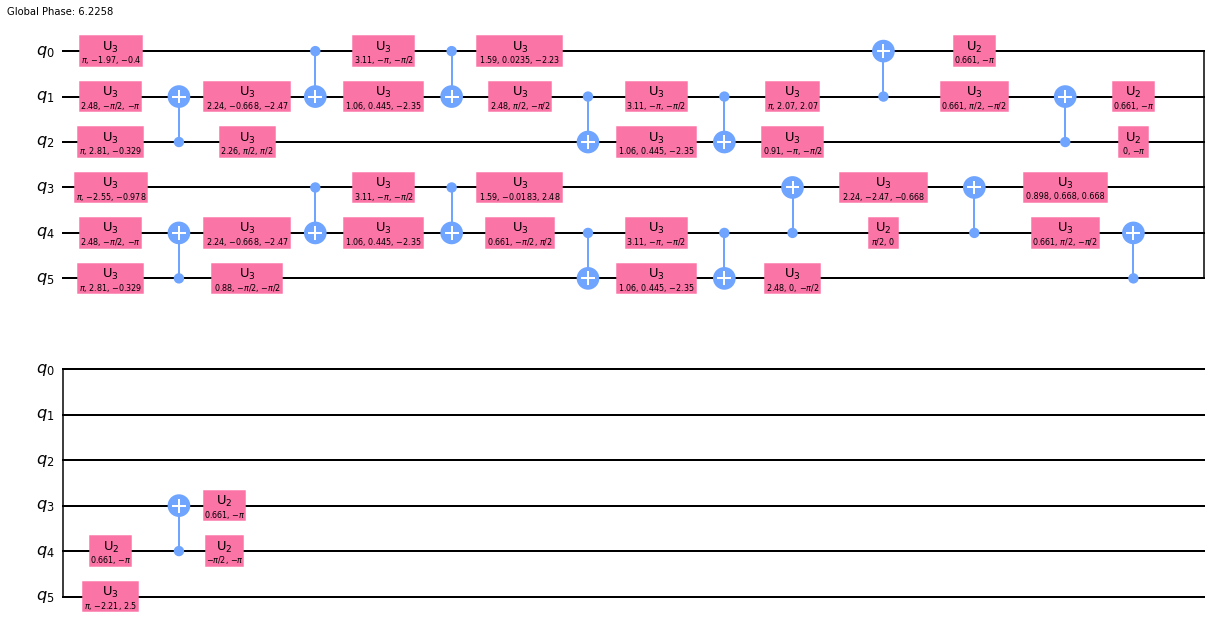

In [197]:
circ=qiskit.transpile(circ,basis_gates=['u1','u2','u3','cx'],optimization_level=3)
circ.draw('mpl')

In [198]:
#after transpilation
circ.decompose().decompose().count_ops()

OrderedDict([('u', 37), ('cx', 16)])

In [199]:
circ1=rand_circ.copy()
circ1=circ1+circ

In [200]:
m1,err1=Energy_Estimator(circ1,rotH,num_shots=2**20)

In [201]:
m1,err1

(-21.60078651732079, 0.008932830751803402)

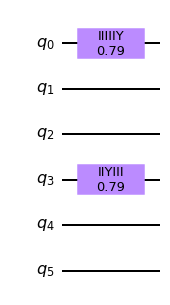

In [160]:
circ_2_body.draw('mpl')